In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
S0 = 100
K = 100
T = 1
r = 0.06
N = 3
u = 1.1
d = 1/u
opttype = 'C'

In [5]:
def binomial_tree(K,T,S0,r,N,u,d,opttype='C',american = False):
  dt = T/N
  q = (np.exp(r*dt) - d)/(u-d)
  disc = np.exp(-r*dt)

  S = np.zeros((N+1, N+1))
  for i in range(N+1):
    for j in range(i+1):
      S[j, i] = S0 * (u ** (i-j)) * (d ** j)

  C = np.zeros((N+1,N+1))
  for j in range(N+1):
    if opttype == 'C':
      C[j, N] = max(0, S[j, N] - K)
    else:
      C[j, N] = max(0, K - S[j, N])

  for i in range(N-1, -1, -1):
    for j in range(i+1):
      C[j, i] = disc * (q * C[j, i+1] + (1-q) * C[j+1, i+1])
      if american:
        if opttype == 'C':
          exercise_value = max(0, S[j, i] - K)
        else:
          exercise_value = max(0, K - S[j, i])
        C[j, i] = max(C[j, i], exercise_value)

  return C[0, 0]

In [6]:
def calculate_greeks(K, T, S0, r, N, u, d, opttype='C', american=False):

  price = binomial_tree(K, T, S0, r, N, u, d, opttype, american)
  dS = 0.01 * S0  # 1% bump
  price_up = binomial_tree(K, T, S0 + dS, r, N, u, d, opttype, american)
  price_down = binomial_tree(K, T, S0 - dS, r, N, u, d, opttype, american)
  delta = (price_up - price_down) / (2 * dS)

  gamma = (price_up - 2*price + price_down) / (dS ** 2)

  dT = 0.01
  if T > dT:
      price_theta = binomial_tree(K, T - dT, S0, r, N, u, d, opttype, american)
      theta = (price_theta - price) / dT
  else:
      theta = 0

  sigma = np.log(u) / np.sqrt(T/N)
  dsigma = 0.01
  u_new = np.exp((sigma + dsigma) * np.sqrt(T/N))
  d_new = 1/u_new
  price_vega = binomial_tree(K, T, S0, r, N, u_new, d_new, opttype, american)
  vega = (price_vega - price) / dsigma

  return {
        'Price': price,
        'Delta': delta,
        'Gamma': gamma,
        'Theta': theta,
        'Vega': vega
    }

In [10]:
stock_prices = np.linspace(80, 120, 41)
euro_call_prices = [binomial_tree(K, T, S, r, 50, u, d, 'C', False) for S in stock_prices]
amer_call_prices = [binomial_tree(K, T, S, r, 50, u, d, 'C', True) for S in stock_prices]
euro_put_prices = [binomial_tree(K, T, S, r, 50, u, d, 'P', False) for S in stock_prices]
amer_put_prices = [binomial_tree(K, T, S, r, 50, u, d, 'P', True) for S in stock_prices]

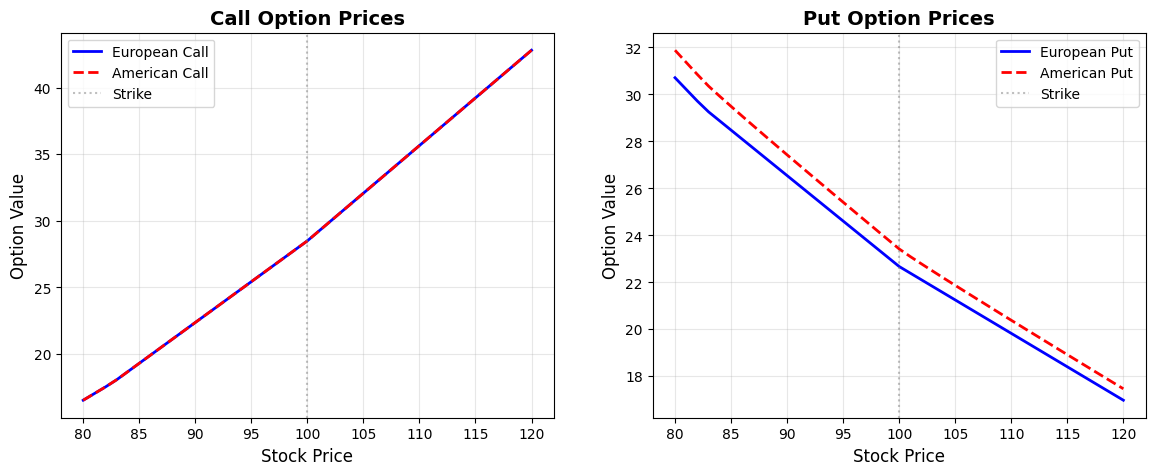

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(stock_prices, euro_call_prices, 'b-', label='European Call', linewidth=2)
axes[0].plot(stock_prices, amer_call_prices, 'r--', label='American Call', linewidth=2)
axes[0].axvline(K, color='gray', linestyle=':', alpha=0.5, label='Strike')
axes[0].set_xlabel('Stock Price', fontsize=12)
axes[0].set_ylabel('Option Value', fontsize=12)
axes[0].set_title('Call Option Prices', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(stock_prices, euro_put_prices, 'b-', label='European Put', linewidth=2)
axes[1].plot(stock_prices, amer_put_prices, 'r--', label='American Put', linewidth=2)
axes[1].axvline(K, color='gray', linestyle=':', alpha=0.5, label='Strike')
axes[1].set_xlabel('Stock Price', fontsize=12)
axes[1].set_ylabel('Option Value', fontsize=12)
axes[1].set_title('Put Option Prices', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

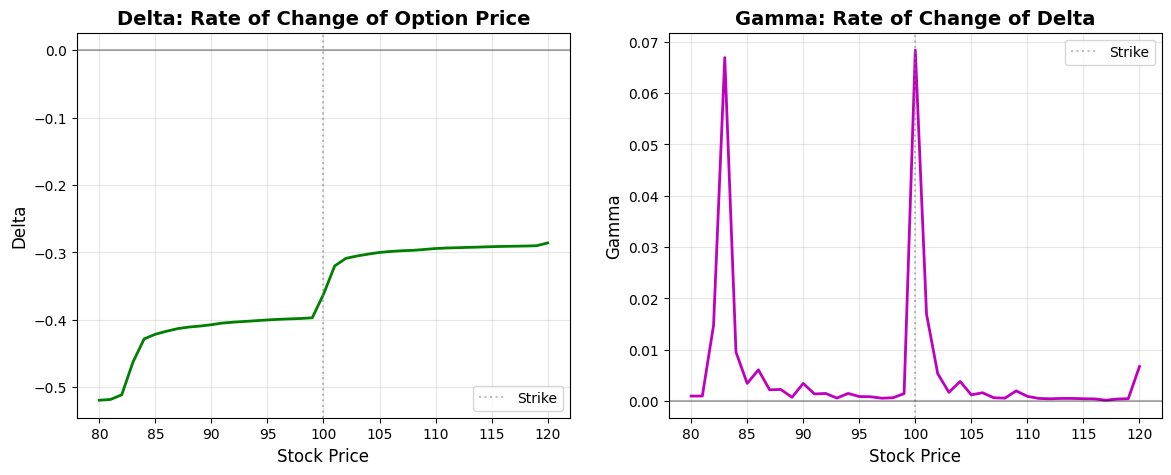

In [13]:
deltas = []
gammas = []

for S in stock_prices:
    greeks = calculate_greeks(K, T, S, r, 50, u, d, 'P', True)
    deltas.append(greeks['Delta'])
    gammas.append(greeks['Gamma'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Delta
axes[0].plot(stock_prices, deltas, 'g-', linewidth=2)
axes[0].axvline(K, color='gray', linestyle=':', alpha=0.5, label='Strike')
axes[0].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[0].set_xlabel('Stock Price', fontsize=12)
axes[0].set_ylabel('Delta', fontsize=12)
axes[0].set_title('Delta: Rate of Change of Option Price', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gamma
axes[1].plot(stock_prices, gammas, 'm-', linewidth=2)
axes[1].axvline(K, color='gray', linestyle=':', alpha=0.5, label='Strike')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Stock Price', fontsize=12)
axes[1].set_ylabel('Gamma', fontsize=12)
axes[1].set_title('Gamma: Rate of Change of Delta', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
